# Train Plots Notebook

This notebook shows the convergance for different method through loss-plots.

First, some global imports:

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../modules')

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn

## Non-Distributed Training

In this section we will train a reference model without distribution to get theoretical results.

Since we are using the MSE loss, it is defined as:

$$
    \frac{1}{N}\|y - (X\cdot w + b)\|^2_2
$$

With $N$ the number of samples, $y\in\mathbb{R}^N$ the targets, $X\in\mathbb{R}^{N\times 2}$ the design matrix, $w\in\mathbb{R}^{2\times 1}$ the weights, and $b\in\mathbb{R}$ the bias.

We have that the Lipschitz constant is:

$$
    L = \frac{2}{N} \|(X')^T\cdot X'\|
$$

Where $X'$ is the column concatenation of $X$ and the ones vector, and $\|\cdot\|$ is the spectral norm.

First, we will load the data and calculate $L$:

In [200]:
from data import get_data

num_samples = 2000


X, y = get_data(num_samples)
N = X.shape[0]

X_ = np.c_[X, np.ones((N, 1))]

w_opt = np.linalg.inv(X_.T@X_)@X_.T@y.numpy() #compute global optimum with normal equations. For strongly convex problems we have a unique minimum. 
diff = (X_@w_opt - y.numpy())
global_opt = (diff*diff).mean()

# same as || X^T X ||
s = np.linalg.svd(X_, compute_uv=False)[0]**2
L = 2/N * s
# same as min eig(X^T X)
s = np.linalg.svd(X_, compute_uv=False)[-1]**2
mu = 2/N * s

print('L :', L)
print('mu :', mu)
print('f(x*) : ', global_opt)

L : 3.5575142116705325
mu : 0.38792338487056194
f(x*) :  0.05307472882123199


Now, we create the Least Squares model and train it,

In [201]:
from graph import model_lr

# best learning rate for GD
lr = 0.01 #1 / L
print('lr :', lr)

# no. of independent runs
runs = 1
# epochs per run
epochs = 2000

losses = np.empty((runs, epochs))

for i in range(runs):
    # set randomness
    np.random.seed(i+1)
    torch.manual_seed(i+1)

    model = model_lr(input_dim=X.shape[1], output_dim=y.shape[1])

    opt = torch.optim.SGD(model.parameters(), lr=lr)
    criteria = nn.MSELoss()

    for j in range(epochs):
        out = model(X)
        l = criteria(out, y)
        losses[i, j] = l.item()
        l.backward()

        opt.step()
        opt.zero_grad()

        if j % 500 == 0:
            print('run :', i, 'i :', j, 'train loss :', losses[i, j])
            
m_gl_losses = losses.mean(axis=0)
l_gl_losses = losses.min(axis=0)
h_gl_losses = losses.max(axis=0)

lr : 0.01
run : 0 i : 0 train loss : 0.40635934472084045
run : 0 i : 500 train loss : 0.05349741876125336
run : 0 i : 1000 train loss : 0.053083401173353195
run : 0 i : 1500 train loss : 0.0530749075114727


## Plots

After obtaining losses for the non-distributed case, we read the CSV containing all the train info:

In [212]:
from pathlib import Path
dfs = []
for i, filename in enumerate(Path('.').glob('out*.csv')):
    df = pd.read_csv(filename)
    dfs += [df]
dfs = pd.concat(dfs, axis=0)
dfs['ind'] = dfs.index
dfs.set_index('ind')
m_dfs = dfs.groupby(['ind', 'topo']).mean()
l_dfs = dfs.groupby(['ind', 'topo']).min()
h_dfs = dfs.groupby(['ind', 'topo']).max()
dfs = m_dfs
dfs['min_loss'] = l_dfs['loss']
dfs['max_loss'] = h_dfs['loss']
del m_dfs, l_dfs, h_dfs
dfs

,,nodes,lr,batch_size,mixing_steps,local_steps,loss,comms,min_loss,max_loss
ind,topo,,,,,,,,,
0,ring,50,0.095871,2000,1,1,0.166331,1200,0.166331,0.166331
1,ring,50,0.095871,2000,1,1,0.129775,2400,0.129775,0.129775
2,ring,50,0.095871,2000,1,1,0.118109,3600,0.118109,0.118109
3,ring,50,0.095871,2000,1,1,0.111904,4800,0.111904,0.111904
4,ring,50,0.095871,2000,1,1,0.107902,6000,0.107902,0.107902
...,...,...,...,...,...,...,...,...,...,...
7995,smallworld,50,0.112124,2000,1,1,0.053233,28670544,0.053233,0.053233
7996,smallworld,50,0.112124,2000,1,1,0.053233,28684908,0.053233,0.053233
7997,smallworld,50,0.112124,2000,1,1,0.053233,28699272,0.053233,0.053233


The plots can get quite cluttered.

Specify here which topologies not to show (leave as `[]` to show all topologies):

In [214]:
exclude_topos = []
exclude_nodes = []

Now we can plot the train losses for the different topologies,

In [204]:
from topos import fc_topo, ring_topo, random_topo, MH_weights, small_world_topo
from utils import get_beta

def ax_annotate_beta(ax, losses, topo, nodes, lr, yoffset):
    if topo == "fc":
        W = fc_topo(nodes)
    elif topo == "random":
        W = MH_weights(random_topo(nodes))
    elif topo == "ring":
        W = ring_topo(nodes)
    elif topo == "smallworld":
        W = MH_weights(small_world_topo(nodes))

    beta = get_beta(W)
    print('beta :', beta)
    N = len(losses)
    ax.annotate(r'$\beta$: 'f'{beta:.3g}',
                (N, losses.iloc[-1]*(1-yoffset)),
                size=14)

random 50 0.01
beta : 0.685473192408765
ring 50 0.01
beta : 0.9947431342096509
smallworld 50 0.01
beta : 0.37771290344751957


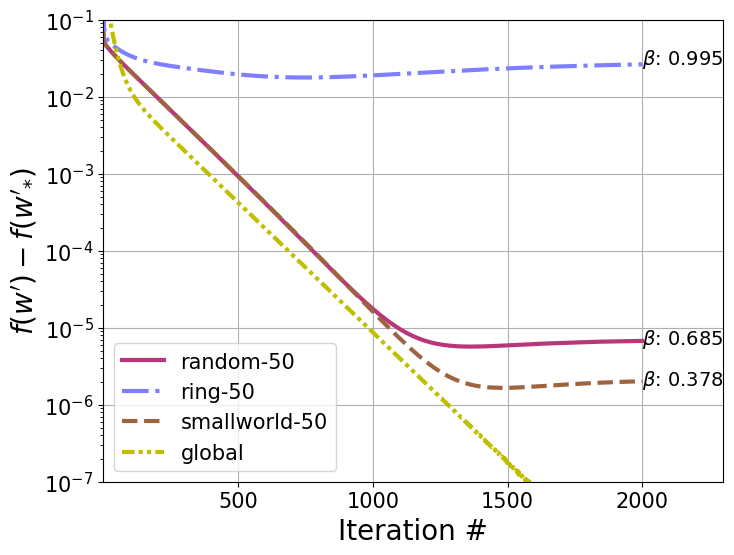

In [211]:
import itertools

# plot options
figsize = (8, 6)
alpha = 0.1  # translucency
shade = False  # show shaded area
lw = 3  # line width
annotate_beta = True # whether to show beta parameter

plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, axes = plt.subplots(1, 1, figsize=figsize)
ax = axes
# ax.set_xscale('log')
ax.set_yscale('log')
cmaps = dict(fc='viridis', random='magma', ring='cool', smallworld='copper')
fmts = itertools.cycle(['-', '-.', '--', ':'])
yoffsets = itertools.cycle([0.1, 0])
for topo, d1 in dfs.groupby('topo'):
    if topo in exclude_topos:
        continue

    cmap = plt.get_cmap(cmaps[topo])
    fmt = next(fmts)
    M = len([_ for _ in d1.groupby('nodes')])

    ind = 0
    for nb_nodes, d2 in d1.groupby('nodes'):
        if nb_nodes in exclude_nodes:
            continue

        count = 0
        for lr, d3 in d2.groupby('lr'):
            count += 1
            if count != 1:
                continue
            print(topo, nb_nodes, lr)

            xaxis = range(1, len(d3['loss'])+1)

            color = cmap(ind*0.5/M + 0.5)
            ind += 1

            ax.plot(xaxis, d3['loss']-global_opt, fmt, lw=lw,
                    label=f'{topo}-{int(nb_nodes)}', color=color)
            if shade:
                ax.fill_between(xaxis,
                                d3['min_loss']-global_opt,
                                d3['max_loss']-global_opt,
                                alpha=alpha, color=color)
            if annotate_beta:
                ax_annotate_beta(ax, d3['loss']-global_opt,
                                 topo, int(nb_nodes), lr, yoffset=next(yoffsets))

p = ax.plot(xaxis, m_gl_losses[:len(xaxis)]-global_opt, 'y', linestyle=(0, (3, 1, 1, 1, 1, 1)), lw=lw, label='global')
color = p[0].get_color()
if shade:
    ax.fill_between(xaxis,
                    l_gl_losses[:len(xaxis)]-global_opt,
                    h_gl_losses[:len(xaxis)]-global_opt,
                    alpha=alpha, color=color)

ax.legend(loc="lower left")
ax.set_xlabel('Iteration #')
ax.set_ylabel(r"$f(w')-f(w'_{*})$")
if annotate_beta:
    ax.set_xlim(1, xaxis[-1]*1.15)
    ax.set_ylim(1e-7, 0.1)
ax.grid()
plt.show()

smallworld 50 0.1144271209652097 1
smallworld 50 0.1144271209652097 2
smallworld 50 0.1144271209652097 3
smallworld 50 0.1144271209652097 4
smallworld 50 0.1144271209652097 5


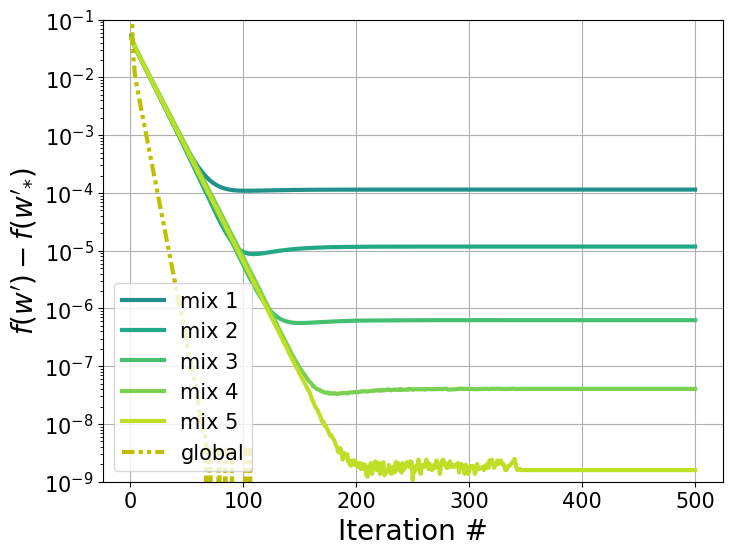

In [171]:
import itertools

# plot options
figsize = (8, 6)
alpha = 0.1  # translucency
shade = False  # show shaded area
lw = 3  # line width
annotate_beta = False # whether to show beta parameter

plt.style.use('default')

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, axes = plt.subplots(1, 1, figsize=figsize)
ax = axes
# ax.set_xscale('log')
ax.set_yscale('log')
cmaps = dict(fc='viridis', random='magma', ring='cool', smallworld='copper')
fmts = itertools.cycle(['-', '-.', '--', ':'])
yoffsets = itertools.cycle([0.1, 0])
for topo, d1 in dfs.groupby('topo'):
    if topo in exclude_topos:
        continue

    cmap = plt.get_cmap(cmaps[topo])
    fmt = next(fmts)
    M = len([_ for _ in d1.groupby('mixing_steps')])
    ind = 0

    for mixing_steps, d2 in d1.groupby('mixing_steps'):
        print(topo, nb_nodes, lr, mixing_steps)

        xaxis = range(1, len(d4['loss'])+1)

        color = cmap(ind*0.5/M + 0.5)
        ind += 1

        ax.plot(xaxis, d2['loss']-global_opt, fmt, lw=lw,
                label=f'mix {int(mixing_steps)}', color=color)
        if shade:
            ax.fill_between(xaxis,
                            d2['min_loss']-global_opt,
                            d2['max_loss']-global_opt,
                            alpha=alpha, color=color)
        if annotate_beta:
            ax_annotate_beta(ax, d3['loss']-global_opt,
                             topo, int(nb_nodes), lr, yoffset=next(yoffsets))

p = ax.plot(xaxis, m_gl_losses[:len(xaxis)]-global_opt, 'y', linestyle=(0, (3, 1, 1, 1, 1, 1)), lw=lw, label='global')
color = p[0].get_color()
if shade:
    ax.fill_between(xaxis,
                    l_gl_losses[:len(xaxis)]-global_opt,
                    h_gl_losses[:len(xaxis)]-global_opt,
                    alpha=alpha, color=color)

ax.legend(loc="lower left")
ax.set_xlabel('Iteration #')
ax.set_ylabel(r"$f(w')-f(w'_{*})$")
if annotate_beta:
    ax.set_xlim(1, xaxis[-1]*1.15)
    ax.set_ylim(1e-7, 0.1)
else:
    ax.set_ylim(1e-9, 0.1)
ax.grid()
plt.show()

Note that the topologies do not converge to the global minimum. There is a theorem which states that they will converge to $O\left(\frac{\alpha}{1-\beta}\right)$-neighborhood of the global minimum, with $\alpha$ the learning rate and $\beta=\min\{|\lambda_2(W)|, |\lambda_n(W)|\}$, where $W$ is the topology matrix.

Let's calculate this neighborhood for the random and ring topologies, the latter which we can see has the worst convergence:

In [71]:
from topos import ring_topo, random_topo, MH_weights, small_world_topo
from utils import get_beta

W_ring = ring_topo(50)
W_random = MH_weights(random_topo(50))
W_smallworld = MH_weights(small_world_topo(50))

lr = 0.001

beta = get_beta(W_ring)
print('RING TOPOLOGY')
print('beta : ', beta)
print('lr / (1 - beta) :', lr / (1 - beta))

beta = get_beta(W_random)
print('RANDOM TOPOLOGY')
print('beta : ', beta)
print('lr / (1 - beta) :', lr / (1 - beta))

beta = get_beta(W_smallworld)
print('SMALL WORLD TOPOLOGY')
print('beta : ', beta)
print('lr / (1 - beta) :', lr / (1 - beta))

RING TOPOLOGY
beta :  0.9947431342096509
lr / (1 - beta) : 0.19022741684519742
RANDOM TOPOLOGY
beta :  0.7007724407753758
lr / (1 - beta) : 0.003341938164356445
SMALL WORLD TOPOLOGY
beta :  0.393216033071819
lr / (1 - beta) : 0.0016480329977445831


### Complexity per iteration

Here, we show the bytes required to achieve a certain threshold of the loss due to communication between nodes.

fc 50 0.1438066700413685
random 50 0.0962535377841267
ring 50 0.0958711133609123
smallworld 50 0.1121244903024012


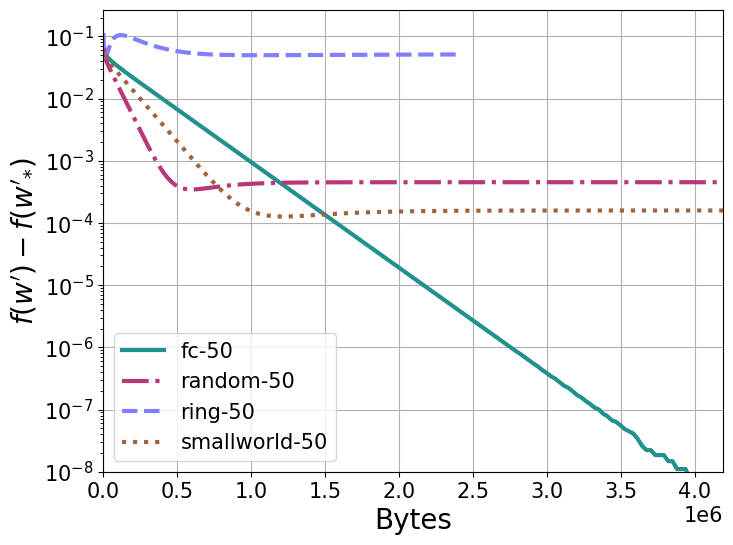

In [217]:
import itertools

# plot options
figsize = (8, 6)
alpha = 0.1
shade = False
lw = 3

fig, axes = plt.subplots(1, 1, figsize=figsize)
ax = axes
# ax.set_xscale('log', base=2)
ax.set_yscale('log')
cmaps = dict(fc='viridis', random='magma', ring='cool', smallworld='copper')
fmts = itertools.cycle(['-', '-.', '--', ':'])
for topo, d1 in dfs.groupby('topo'):
    if topo in exclude_topos:
        continue

    cmap = plt.get_cmap(cmaps[topo])
    fmt = next(fmts)
    M = len([_ for _ in d1.groupby('nodes')])

    ind = 0
    for nb_nodes, d2 in d1.groupby('nodes'):
        if nb_nodes in exclude_nodes:
            continue

        count = 0
        for lr, d3 in d2.groupby('lr'):
            count += 1
            if count != 1:
                continue
            print(topo, nb_nodes, lr)

            xaxis = d2['comms']

            color = cmap(ind*0.5/M + 0.5)
            ind += 1

            ax.plot(xaxis, d2['loss']-global_opt, fmt, label=f'{topo}-{int(nb_nodes)}', lw=lw, color=color)
            if shade:
                ax.fill_between(xaxis,
                                d2['loss']-global_opt-d2['loss_std'],
                                d2['loss']-global_opt+d2['loss_std'],
                                alpha=alpha, color=color)

ax.legend(loc="lower left")
ax.set_xlabel('Bytes')
ax.set_ylabel(r"$f(w')-f(w'_{*})$")
ax.grid()
plt.ylim(1e-8, None)
plt.xlim(0, 2**22)
plt.show()

fc 50 0.1144271209652097 1
smallworld 50 0.1144271209652097 1
smallworld 50 0.1144271209652097 2
smallworld 50 0.1144271209652097 3


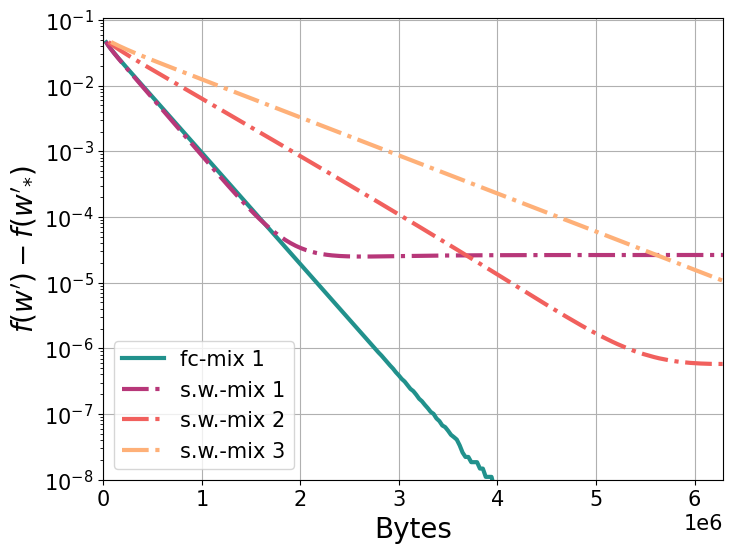

In [198]:
import itertools

# plot options
figsize = (8, 6)
alpha = 0.1
shade = False
lw = 3

fig, axes = plt.subplots(1, 1, figsize=figsize)
ax = axes
# ax.set_xscale('log', base=2)
ax.set_yscale('log')
cmaps = itertools.cycle(['viridis', 'magma', 'cool', 'copper'])
fmts = itertools.cycle(['-', '-.', '--', ':'])
for topo, d1 in dfs.groupby('topo'):
    if topo in exclude_topos:
        continue

    cmap = plt.get_cmap(next(cmaps))
    fmt = next(fmts)
    M = len([_ for _ in d1.groupby('mixing_steps')])

    ind = 0
    for mixing_steps, d2 in d1.groupby('mixing_steps'):
        if mixing_steps > 3:
            continue
        print(topo, nb_nodes, lr, mixing_steps)

        xaxis = d2['comms']

        color = cmap(ind*0.5/M + 0.5)
        ind += 1

        if topo == "smallworld":
            topo_str = "s.w."
        else:
            topo_str = topo

        ax.plot(xaxis, d2['loss']-global_opt, fmt,
                label=f'{topo_str}-mix {int(mixing_steps)}', lw=lw, color=color)
        if shade:
            ax.fill_between(xaxis,
                            d2['loss']-global_opt-d2['loss_std'],
                            d2['loss']-global_opt+d2['loss_std'],
                            alpha=alpha, color=color)

ax.legend(loc="lower left")
ax.set_xlabel('Bytes')
ax.set_ylabel(r"$f(w')-f(w'_{*})$")
ax.grid()
plt.ylim(1e-8, None)
plt.xlim(0, 1.5*2**22)
plt.show()